In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer 
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import kcpredict.data.make_data as make_data 
import kcpredict.data.preprocess as preprocess_data

FEATURES = {"2024_variouscrop":
                [
                    "DOY", "Tmin", "Tmax", "Tdew", "Uwind", "Vwind", "Rs",
                    "ETo"
                ]
            }

SCALE = True
FOLDS = 2

In [21]:
raw_data = "G:/UNIPA/DOTTORATO/MACHINE_LEARNING/crop_coefficient/kc-predict/data/raw/data_us_arm.csv"

In [22]:
data = make_data.get_raw_data(raw_data)

## Data Preprocessing

In [23]:
features = FEATURES["2024_variouscrop"]
df = preprocess_data.make_dataframe(data, features)
print("Percentage of missing values:")
df.isna().sum() / df.sum() * 100

Percentage of missing values:


DOY       0.000000
Tmin      0.000000
Tmax      0.000000
Tdew      0.000000
Uwind    -0.000000
Vwind     0.000000
Rs        0.000000
ETo       0.000000
ETa      13.053346
dtype: float64

### Impute missing values

In [24]:
df = preprocess_data.impute_features(df, features)
print("Percentage of missing values after imputation:")
df.isna().sum() / df.sum() * 100

Percentage of missing values after imputation:


DOY       0.000000
Tmin      0.000000
Tmax      0.000000
Tdew      0.000000
Uwind    -0.000000
Vwind     0.000000
Rs        0.000000
ETo       0.000000
ETa      13.053346
dtype: float64

array([<AxesSubplot:xlabel='Day'>, <AxesSubplot:xlabel='Day'>,
       <AxesSubplot:xlabel='Day'>, <AxesSubplot:xlabel='Day'>,
       <AxesSubplot:xlabel='Day'>, <AxesSubplot:xlabel='Day'>,
       <AxesSubplot:xlabel='Day'>, <AxesSubplot:xlabel='Day'>,
       <AxesSubplot:xlabel='Day'>], dtype=object)

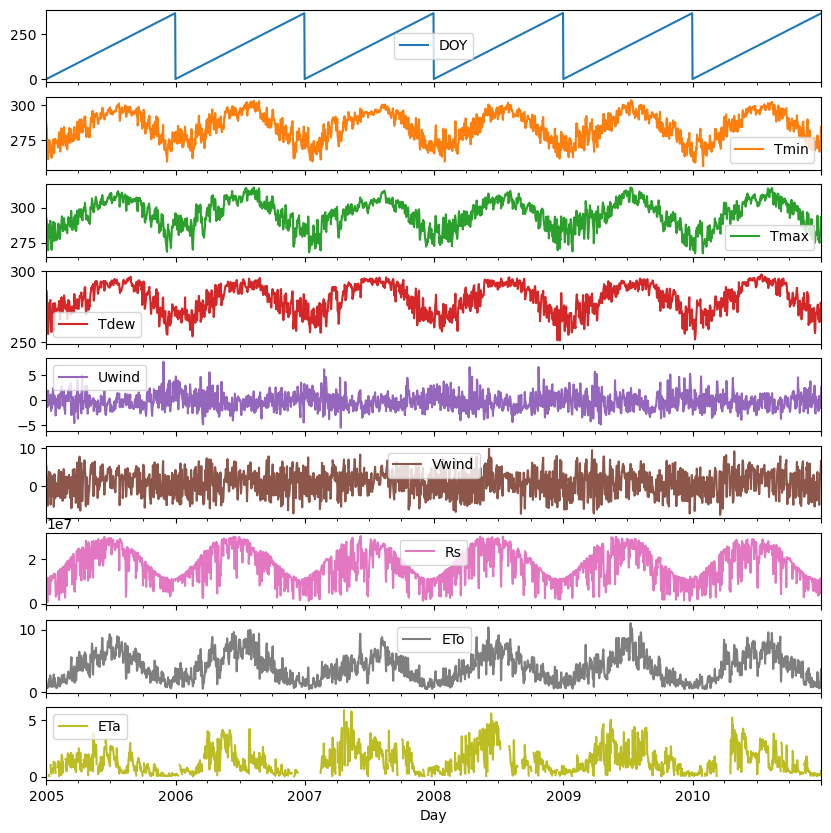

In [58]:
df.plot(subplots=True, figsize=(10, 10))

### Split data for Cross Validation

In [25]:
X, y = df.dropna().drop(columns=["ETa"]), df.dropna()["ETa"]
folds = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
train_index, test_index = list(folds.split(X))[0]
print(f"Train data: {len(train_index)} - Test data: {len(test_index)}")

Train data: 929 - Test data: 929


### Scale data

In [26]:
scaler = StandardScaler()

## Train Model

In [95]:
def train_test_split(df, model, folds, scaler=None):
    X, y = df.dropna().drop(columns=["ETa"]), df.dropna()["ETa"]
    
    r2s = np.zeros(folds.n_splits)
    rmses = np.zeros(folds.n_splits)
    
    for i, (train_index, test_index) in enumerate(folds.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if SCALE:
            X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
            X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
            y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
            y_test = scaler.transform(y_test.values.reshape(-1, 1)).ravel()
            
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2s[i] = r2_score(y_test, y_pred)
        rmses[i] = np.sqrt(mean_squared_error(y_test, y_pred))
        
        if r2s.max() == r2s[i]:
            X_predict = df.drop(X_train.index).drop(columns=["ETa"])
            y_true = df.drop(X_train.index)["ETa"]
            y_pred = pd.DataFrame(model.predict(X_predict), index=y_true.index)
        
    print(f"Mean R2: {np.mean(r2s)}")
    print(f"Mean RMSE: {np.mean(rmses)}")
    print("_"*50)
    print(f"Max R2: {np.max(r2s)}")
    print(f"Max RMSE: {np.max(rmses)}")
    return y_pred

### Try various Models

In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ExpSineSquared, RationalQuadratic

In [97]:
model = RandomForestRegressor(n_estimators=1000, max_depth=None, random_state=42, ccp_alpha=0.0, n_jobs=4)

In [98]:
y_pred = train_test_split(df, model, folds, scaler)

Mean R2: 0.574557302352743
Mean RMSE: 0.6525821401611147
__________________________________________________
Max R2: 0.5865928511079492
Max RMSE: 0.6768931610443633


In [31]:
model = MLPRegressor(hidden_layer_sizes=(100, 1000, 100), max_iter=1000,random_state=32652)

In [32]:
r2s, rmses = train_test_split(X, y, model, folds, scaler)

Mean R2: 0.4043279705166983
Mean RMSE: 0.7716203787258786
__________________________________________________
Max R2: 0.43337240477610406
Max RMSE: 0.7924648272960936


In [99]:
kernel = ExpSineSquared(length_scale=1.0, periodicity=1.0) + WhiteKernel(noise_level=0.5)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=120.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.5**2 * RBF(length_scale=0.5) + WhiteKernel(
    noise_level=0.2**2, noise_level_bounds=(1e-6, 1e6)
)
kernel = (
    seasonal_kernel 
    + 50.0**2 * RBF(length_scale=50.0)
    + noise_kernel
    # + irregularities_kernel
)
model = GaussianProcessRegressor(kernel=kernel, random_state=42, n_restarts_optimizer=10, normalize_y=True, alpha=0.1)

In [100]:
y_pred = train_test_split(df, model, folds, scaler)

C:\Users\fedes\anaconda3\envs\ml\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\fedes\anaconda3\envs\ml\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Mean R2: 0.5775803972793514
Mean RMSE: 0.6503461153760759
__________________________________________________
Max R2: 0.5877865017080107
Max RMSE: 0.6759152413359643


In [103]:
train_index, _ = list(folds.split(X))[np.argmax(np.array(r2s))]
X_train, y_train = X.iloc[train_index], y.iloc[train_index]
y_true = df.drop(X_train.index)["ETa"]
y_pred = pd.DataFrame(y_pred, index=y_true.index)

ValueError: Shape of passed values is (929, 1), indices imply (1262, 1)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

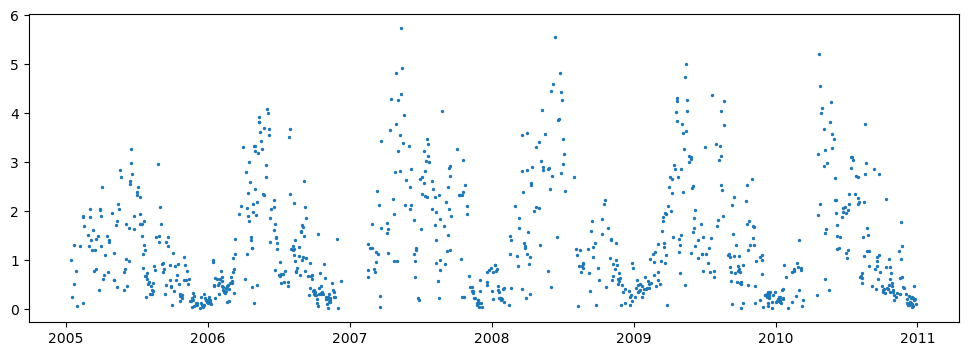

In [102]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(y_true.index, y_true, label="True", s=2)
ax.scatter(y_pred.index, y_pred, label="Predicted", s=2)
ax.scatter(y_train.index, y_train, label="Train", s=2)
ax.grid()
ax.legend()